We implement HeteroPCA below (Heteroskedastic PCA: Algorithm, optimality, and applications by ANRU R. ZHANG, T. TONY CAI AND YIHONG WU) and use this algorithm to get better visualizations on the StockX dataset.

This dataset contains information on about 100,000 sneaker sales on StockX from 2017 to 2019.

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%cd /Users/sosuke/Downloads/Stockxproject

/Users/sosuke/Downloads/Stockxproject


In [75]:
df = pd.read_excel('StockX-Data-Contest-2019-3.xlsx')

In [76]:
df.head()

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097.0,220,2016-09-24,11.0,California
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685.0,220,2016-11-23,11.0,California
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690.0,220,2016-11-23,11.0,California
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075.0,220,2016-11-23,11.5,Kentucky
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828.0,220,2017-02-11,11.0,Rhode Island


We first calculate the profit of this sale and create an indicator variable for whether the sale was profitable for the seller or not.

In [77]:
df['profit'] = (df['Sale Price'] - df['Retail Price'])*0.87
df['profit_dummy'] =df['profit']>0
df['profit_dummy'] = df['profit_dummy'].astype(int)

We then extract years, months, and dates from order dates of sales and release dates of the sneakers.

In [78]:
df['Days_since_released']=(df['Order Date']-df['Release Date']).dt.days
df['order_year']=df['Order Date'].dt.year
df['release_year']=df['Release Date'].dt.year
df['order_month']=df['Order Date'].dt.month
df['release_month']=df['Release Date'].dt.month
df['order_day']=df['Order Date'].dt.day
df['release_day']=df['Release Date'].dt.day

Next, we make all these categorical variables into binary variables. One of the applications of HeteroPCA is a dataset with binary variables, as variance of binary variables often differ. 

In [79]:
#df = pd.get_dummies(df, columns=['Brand','Sneaker Name','Buyer Region'])
df = pd.get_dummies(df, columns=['Brand','Buyer Region', 'order_year', 'Retail Price',
                                 'release_year', 'order_month','release_month','order_day','release_day'])

In [80]:
df.rename({'Brand_ Yeezy': 'Brand_Yeezy', 'Brand_Off-White': 'Brand_Off_White','Sneaker Name': 'Sneaker_Name'}, axis=1, inplace=True)

You can easily see as below that $p$'s for these binomial variables are different, which implies that the errors are heteroskedastic between different variables.

In [114]:
df.release_year_2018.value_counts()

0    53364
1    46592
Name: release_year_2018, dtype: int64

In [115]:
df.release_year_2019.value_counts()

0    98585
1     1371
Name: release_year_2019, dtype: int64

In [82]:
# HeteroPCA algorithm

def HeteroPCA(Sig, rank, error, max_iter=3000):
    N = Sig.copy()
    ND = Sig.copy()
    np.fill_diagonal(ND, 0)
    np.fill_diagonal(N, 0)
    t=0
    while True:
        U,S,V = np.linalg.svd(N, full_matrices=False, hermitian=True)
        D = np.dot(np.dot(U[:,:rank],np.diag(S[:rank])),V[:rank,:])
        #print(S[rank:])
        N_new = ND.copy()
        #print(ND)
        #print(np.diagonal(N_new))
        for i in range(N.shape[0]):
            N_new[i,i] = D[i,i]
        #print(np.diag(N_new))
        #print(np.linalg.norm(np.diagonal(Sig)-np.diagonal(N_new)))
        #print(np.linalg.norm(N-N_new))
        if np.linalg.norm(N-N_new) < error or t > max_iter:
            break
        #print(np.diagonal(N_new))
        N = N_new.copy()
        t+=1
        
    
    return U[:,:rank]

Here, we drop variables that are not binary, since HeteroPCA assumes that variables come from some kind of multinomial distribution (distributions of variables cannot be different).

In [83]:
# Sample covariance matrix

#C = df.drop(['Order Date', 'Sneaker_Name', 'Release Date', 'profit', 'Brand_Yeezy','Brand_Off_White'],axis=1)
C = df.drop(['Order Date', 'Sneaker_Name','Sale Price', 'Release Date', 'Shoe Size', 'profit', 'Days_since_released','Brand_Yeezy','Brand_Off_White'],axis=1)
#C = df.drop(['Order Date', 'profit', 'Sale Price', 'Release Date', 'profit_dummy'], axis=1)
#gram = np.array(C.corr())
C_centered = C - C.mean()
gram = np.dot(np.transpose(C_centered),C_centered)

In [84]:
# Apply HeteroPCA on gram matrix

pc = HeteroPCA(gram,3,0.1)

In [85]:
# transformed (mean-centered) data

plot_points = np.dot(C_centered,pc)

Below is the classical PCA applied to the same data.

In [87]:
U,S,V = np.linalg.svd(gram, full_matrices=False, hermitian=True)
plot_points_reg = np.dot(C_centered,-U)

In [99]:
colors = ListedColormap(['r','b'])
classes = ['Off-White', 'Yeezy']

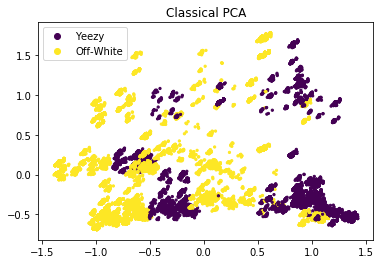

In [101]:
scatter = plt.scatter(plot_points_reg[:,0],plot_points_reg[:,1], s=5, c=df.Brand_Yeezy.astype('category').cat.codes)
plt.title('Classical PCA')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

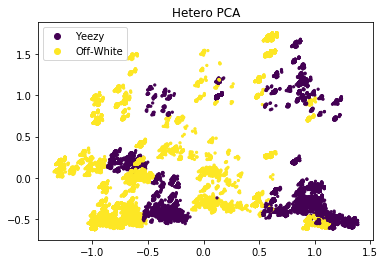

In [102]:
plt.scatter(plot_points[:,0],plot_points[:,1], s=5, c=df.Brand_Yeezy.astype('category').cat.codes)
plt.title('Hetero PCA')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

Although the differences in the above plots are subtle, you can see that there are fewer overlaps between Yeezy and Off-White sneakers in the plot below (HeteroPCA). This allows us to get a better visualization between Yeezy and Off-White sneakers in terms of these binary variables that we created/had in the dataset. The reason why we get a better visualization could be because HeteroPCA is better at retrieving "true" eigenvectors of the covariance matrix than the classical PCA in the presense of Heteroskedastic noise, as argued in the paper.